### Verificar GPU

In [1]:
import tensorflow as tf

# Verificar dispositivos disponíveis
devices = tf.config.list_physical_devices()
print("Dispositivos disponíveis:")
for device in devices:
    print(f"- {device.device_type}: {device.name}")

# Verificar se a GPU está sendo utilizada
if tf.config.list_physical_devices('GPU'):
    print("\nGPU está disponível e será utilizada pelo TensorFlow!")
    print(f"Dispositivo GPU detectado: {tf.test.gpu_device_name()}")
else:
    print("\nGPU não está disponível. O TensorFlow está utilizando a CPU.")

Dispositivos disponíveis:
- CPU: /physical_device:CPU:0
- GPU: /physical_device:GPU:0

GPU está disponível e será utilizada pelo TensorFlow!
Dispositivo GPU detectado: /device:GPU:0


### FLUXO

Found 3151 images belonging to 3 classes.
Found 758 images belonging to 3 classes.
Found 882 images belonging to 3 classes.
Classes e índices do modelo: {'fundo': 0, 'notovelha': 1, 'ovelha': 2}
Class Weights Ajustados: {0: 1.5333333333333334, 1: 0.6085361143298571, 2: 2.838738738738739}
Epoch 1/100
394/394 [==============================] - ETA: 0s - loss: 0.0791 - accuracy: 0.6690     
Epoch 1: saving model to EfficientNetB3_transfer_learning_best_model_512.h5
394/394 [==============================] - 226s 532ms/step - loss: 0.0791 - accuracy: 0.6690 - val_loss: 0.0311 - val_accuracy: 0.8681 - lr: 1.0000e-04
Epoch 2/100
394/394 [==============================] - ETA: 0s - loss: 0.0294 - accuracy: 0.8591  
Epoch 2: saving model to EfficientNetB3_transfer_learning_best_model_512.h5
394/394 [==============================] - 197s 501ms/step - loss: 0.0294 - accuracy: 0.8591 - val_loss: 0.0240 - val_accuracy: 0.8813 - lr: 1.0000e-04
Epoch 3/100
394/394 [==============================] -

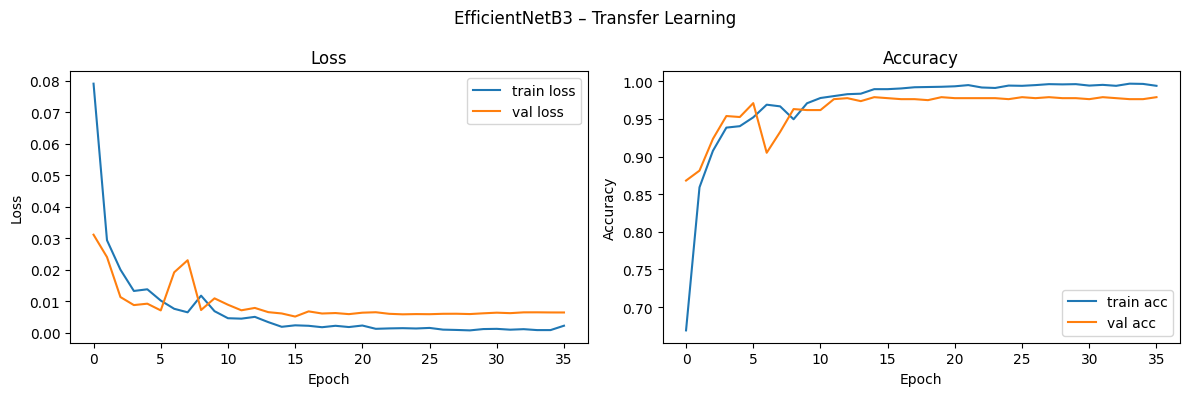

Epoch 1/100
394/394 [==============================] - ETA: 0s - loss: 0.0754 - accuracy: 0.6890     
Epoch 1: saving model to EfficientNetB3_fine_tuning_best_model_512.h5
394/394 [==============================] - 95s 213ms/step - loss: 0.0754 - accuracy: 0.6890 - val_loss: 0.0268 - val_accuracy: 0.8773 - lr: 1.0000e-04
Epoch 2/100
394/394 [==============================] - ETA: 0s - loss: 0.0313 - accuracy: 0.8648  
Epoch 2: saving model to EfficientNetB3_fine_tuning_best_model_512.h5
394/394 [==============================] - 84s 212ms/step - loss: 0.0313 - accuracy: 0.8648 - val_loss: 0.0179 - val_accuracy: 0.9077 - lr: 1.0000e-04
Epoch 3/100
394/394 [==============================] - ETA: 0s - loss: 0.0184 - accuracy: 0.9191  
Epoch 3: saving model to EfficientNetB3_fine_tuning_best_model_512.h5
394/394 [==============================] - 83s 210ms/step - loss: 0.0184 - accuracy: 0.9191 - val_loss: 0.0179 - val_accuracy: 0.9235 - lr: 1.0000e-04
Epoch 4/100
394/394 [================

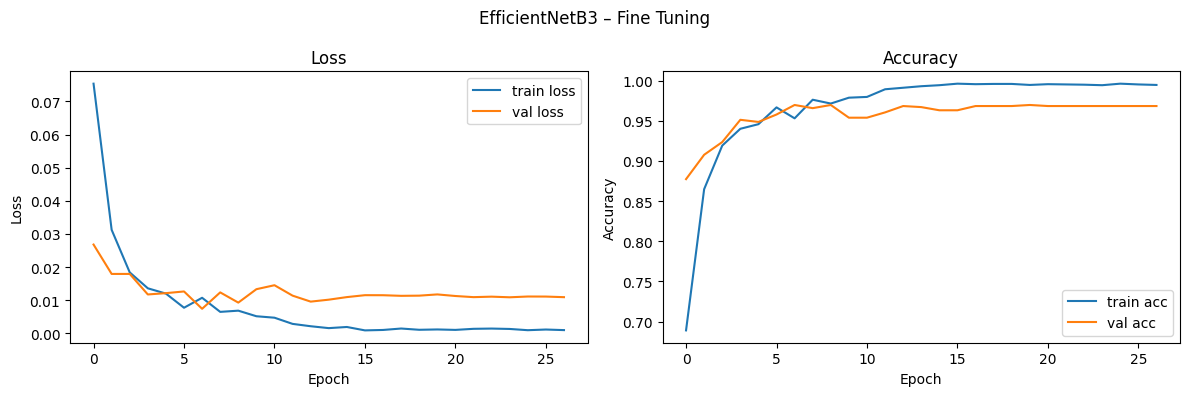

Avaliando EfficientNetB3 (fine_tuning) no conjunto de teste...
111/111 [==============================] - 24s 200ms/step
              precision    recall  f1-score   support

       fundo       0.98      0.98      0.98       168
   notovelha       0.98      0.91      0.95       537
      ovelha       0.80      0.97      0.88       177

    accuracy                           0.94       882
   macro avg       0.92      0.95      0.93       882
weighted avg       0.94      0.94      0.94       882



In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications.efficientnet import preprocess_input as preprocess_efficientnet
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
import tensorflow as tf

# Carregar os dados
def load_data(train_dir, val_dir, test_dir, target_size=(512, 512), batch_size=8, preprocess_fn=None):
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_fn,
        horizontal_flip=True,
        brightness_range=(0.8, 1.2)
    )
    val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_fn)
    
    train_data = train_datagen.flow_from_directory(
        train_dir, target_size=target_size, batch_size=batch_size, class_mode='categorical', shuffle=True
    )
    val_data = val_test_datagen.flow_from_directory(
        val_dir, target_size=target_size, batch_size=batch_size, class_mode='categorical', shuffle=True
    )
    test_data = val_test_datagen.flow_from_directory(
        test_dir, target_size=target_size, batch_size=batch_size, class_mode='categorical', shuffle=False
    )
    return train_data, val_data, test_data

# Construir o modelo
def build_model(base_model_fn, num_classes, trainable_layers=0):
    base_model = base_model_fn(weights='imagenet', include_top=False, input_shape=(512, 512, 3))
    for layer in base_model.layers[:-trainable_layers]:
        layer.trainable = False
    
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.5),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Função para calcular a Focal Loss
def focal_loss(gamma=2.0, alpha=0.25):
    def loss_fn(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
        ce_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
        pt = tf.reduce_sum(y_true * y_pred, axis=-1)
        return alpha * tf.pow(1. - pt, gamma) * ce_loss
    return loss_fn

# Função para plotar curvas de treinamento
def plot_history(history, title=None):
    plt.figure(figsize=(12, 4))
    
    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.title('Loss')
    if title:
        plt.suptitle(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='train acc')
    plt.plot(history.history['val_accuracy'], label='val acc')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Função para treinar o modelo (retorna history)
def train_model(model, train_data, val_data, cnn_name, stage, class_weight=None, learning_rate=0.0001, epochs=100):
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=focal_loss(alpha=0.25, gamma=2),
        metrics=['accuracy']
    )
    
    callbacks = [
        EarlyStopping(monitor='val_loss', mode='min', patience=20, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6, verbose=1),
        ModelCheckpoint(
            filepath=f"{cnn_name}_{stage}_best_model_512.h5",
            monitor='val_loss', mode='min',
            save_best_only=False, save_weights_only=True, verbose=1
        )
    ]
    
    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=epochs,
        callbacks=callbacks,
        class_weight=class_weight,
        verbose=1
    )
    return history

# Avaliação do modelo
def evaluate_model(model, test_data, class_indices, cnn_name, stage):
    print(f"Avaliando {cnn_name} ({stage}) no conjunto de teste...")
    predictions = model.predict(test_data, verbose=1)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = test_data.classes
    report = classification_report(true_classes, predicted_classes, target_names=list(class_indices.keys()))
    print(report)

# Função principal modificada para EfficientNetB3
def main(train_dir, val_dir, test_dir, cnn_name, output_file):
    train_data, val_data, test_data = load_data(
        train_dir, val_dir, test_dir, preprocess_fn=preprocess_efficientnet
    )
    print("Classes e índices do modelo:", train_data.class_indices)

    num_classes = len(train_data.class_indices)
    class_weight = compute_class_weight('balanced', classes=np.arange(num_classes), y=train_data.classes)
    class_weight_dict = dict(enumerate(class_weight))
    
    # Aumentar peso da classe "ovelha"
    ovelha_label = train_data.class_indices.get("ovelha")
    if ovelha_label is not None:
        class_weight_dict[ovelha_label] *= 2.0
    
    print("Class Weights Ajustados:", class_weight_dict)

    # Transfer learning
    model = build_model(EfficientNetB3, num_classes, trainable_layers=0)
    history_tl = train_model(
        model, train_data, val_data, cnn_name,
        "transfer_learning", class_weight=class_weight_dict, epochs=100
    )
    plot_history(history_tl, title=f"{cnn_name} – Transfer Learning")
    
    # Fine tuning (destravando metade das camadas)
    total_layers = len(EfficientNetB3(weights='imagenet', include_top=False).layers)
    model = build_model(EfficientNetB3, num_classes, trainable_layers=total_layers // 2)
    history_ft = train_model(
        model, train_data, val_data, cnn_name,
        "fine_tuning", class_weight=class_weight_dict, epochs=100
    )
    plot_history(history_ft, title=f"{cnn_name} – Fine Tuning")
    
    # Avaliação
    evaluate_model(model, test_data, train_data.class_indices, cnn_name, "fine_tuning")

# Executa o script principal
if __name__ == "__main__":
    main("train", "val", "test", "EfficientNetB3", "EfficientNetB3_results_512.xlsx")

## AVALIAÇÃO TESTE

Found 882 images belonging to 3 classes.
🔹 Reconstruindo e carregando pesos do modelo: Transfer Learning
🔹 Realizando previsões...
111/111 [==============================] - 17s 133ms/step

📌 Relatório de Classificação - Transfer Learning:
              precision    recall  f1-score   support

       fundo       0.99      1.00      0.99       168
   notovelha       1.00      0.91      0.95       537
      ovelha       0.80      0.99      0.88       177

    accuracy                           0.95       882
   macro avg       0.93      0.97      0.94       882
weighted avg       0.95      0.95      0.95       882


📌 Matriz de Confusão - Transfer Learning:
 [[168   0   0]
 [  2 491  44]
 [  0   2 175]]


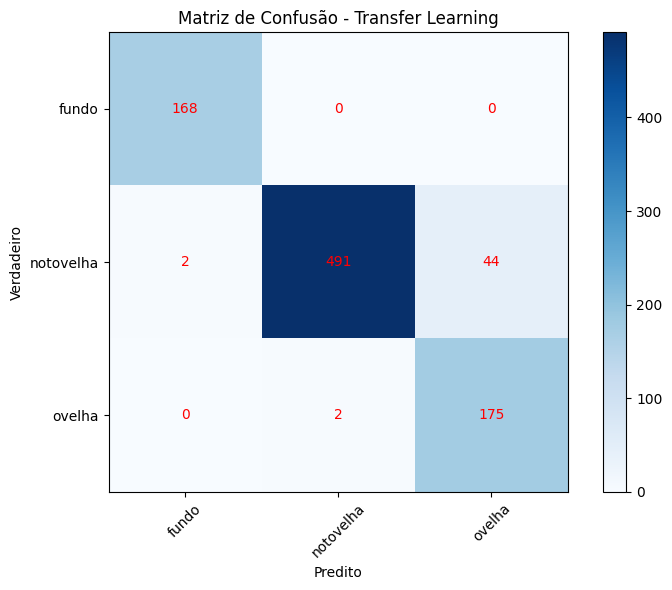

🔹 Reconstruindo e carregando pesos do modelo: Fine Tuning
🔹 Realizando previsões...
111/111 [==============================] - 17s 133ms/step

📌 Relatório de Classificação - Fine Tuning:
              precision    recall  f1-score   support

       fundo       0.98      0.98      0.98       168
   notovelha       0.98      0.91      0.95       537
      ovelha       0.80      0.97      0.88       177

    accuracy                           0.94       882
   macro avg       0.92      0.95      0.93       882
weighted avg       0.94      0.94      0.94       882


📌 Matriz de Confusão - Fine Tuning:
 [[165   3   0]
 [  4 491  42]
 [  0   6 171]]


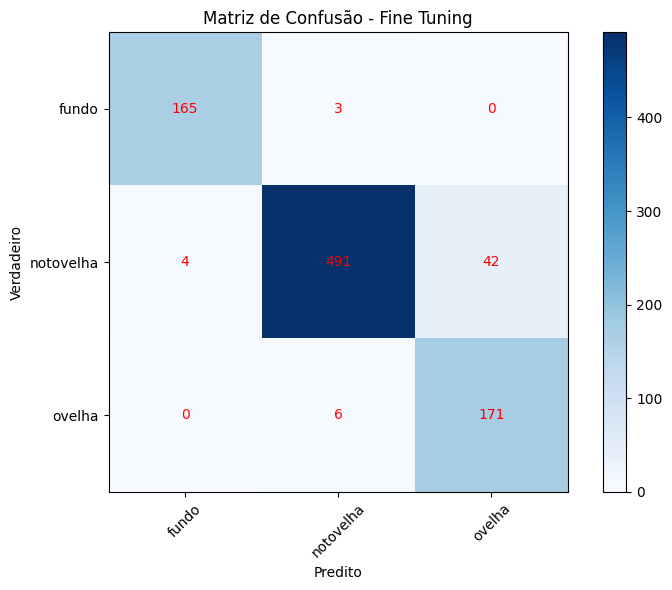

In [8]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications.efficientnet import preprocess_input as preprocess_efficientnet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import tensorflow as tf

# Focal Loss
def focal_loss(gamma=2., alpha=0.25):
    def loss_fn(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
        ce_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
        pt = tf.reduce_sum(y_true * y_pred, axis=-1)
        return alpha * tf.pow(1. - pt, gamma) * ce_loss
    return loss_fn

# Carregar dados
def load_data(test_dir, target_size=(512, 512), batch_size=8, preprocess_fn=None):
    test_datagen = ImageDataGenerator(preprocessing_function=preprocess_fn)
    return test_datagen.flow_from_directory(
        test_dir, target_size=target_size, batch_size=batch_size, class_mode='categorical', shuffle=False
    )

# Reconstruir o modelo Sequential (como no script de treinamento)
def build_model(base_model_fn, num_classes, trainable_layers=0):
    base_model = base_model_fn(weights='imagenet', include_top=False, input_shape=(512, 512, 3))
    for layer in base_model.layers[:-trainable_layers]:
        layer.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.5),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Avaliar modelo
def evaluate_model(model_path, test_data, model_name, trainable_layers=0):
    num_classes = test_data.num_classes
    class_names = list(test_data.class_indices.keys())

    print(f"🔹 Reconstruindo e carregando pesos do modelo: {model_name}")
    model = build_model(EfficientNetB3, num_classes, trainable_layers=trainable_layers)
    model.compile(optimizer='adam', loss=focal_loss(), metrics=['accuracy'])
    model.load_weights(model_path)

    print(f"🔹 Realizando previsões...")
    predictions = model.predict(test_data, verbose=1)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = test_data.classes

    # Relatório
    report = classification_report(true_classes, predicted_classes, target_names=class_names, output_dict=True)
    print(f"\n📌 Relatório de Classificação - {model_name}:")
    print(classification_report(true_classes, predicted_classes, target_names=class_names))

    # Matriz de confusão
    cm = confusion_matrix(true_classes, predicted_classes)
    print(f"\n📌 Matriz de Confusão - {model_name}:\n", cm)

    # Gráfico
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title(f"Matriz de Confusão - {model_name}")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            plt.text(j, i, str(cm[i, j]), ha="center", va="center", color="red")
    plt.xlabel("Predito")
    plt.ylabel("Verdadeiro")
    plt.tight_layout()
    plt.show()

    # Retornar métricas
    weighted_avg = report['weighted avg']
    return {
        'Precision': weighted_avg['precision'],
        'Recall': weighted_avg['recall'],
        'F1-Score': weighted_avg['f1-score'],
        'Accuracy': report['accuracy']
    }

# Avaliação
test_dir = "test"
test_data = load_data(test_dir, preprocess_fn=preprocess_efficientnet)

# Caminhos dos pesos salvos
metrics_tl = evaluate_model("EfficientNetB3_transfer_learning_best_model_512.h5", test_data, "Transfer Learning", trainable_layers=0)
metrics_ft = evaluate_model("EfficientNetB3_fine_tuning_best_model_512.h5", test_data, "Fine Tuning", trainable_layers=len(EfficientNetB3(weights='imagenet', include_top=False).layers)//2)

In [4]:
import os
import shutil
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.efficientnet import preprocess_input as preprocess_efficientnet
import tensorflow as tf

# Redefinir a função focal_loss
def focal_loss(gamma=2., alpha=0.25):
    def loss_fn(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
        ce_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
        pt = tf.reduce_sum(y_true * y_pred, axis=-1)
        focal_loss = alpha * tf.pow(1. - pt, gamma) * ce_loss
        return focal_loss
    return loss_fn

# Função para classificar e organizar as imagens com um intervalo de confiança
def classify_images_by_index(model_path, test_dir, target_size=(512, 512), preprocess_fn=None, confidence_threshold=0.7):
    """
    Usa o modelo para classificar imagens e organiza por índices numéricos com base em um intervalo de confiança.
    """
    print(f"Carregando o modelo salvo de {model_path}...")
    # Carregar o modelo com a função de perda personalizada
    model = load_model(model_path, custom_objects={'loss_fn': focal_loss()})

    # Iterar pelos subdiretórios principais dentro do diretório de teste
    for subdir in os.listdir(test_dir):
        subdir_path = os.path.join(test_dir, subdir)

        # Ignorar se não for um diretório
        if not os.path.isdir(subdir_path):
            continue

        # Caminho da subpasta 'images'
        images_path = os.path.join(subdir_path, "images")
        if not os.path.exists(images_path):
            print(f"Subpasta 'images' não encontrada em {subdir_path}, ignorando...")
            continue

        print(f"Processando diretório: {subdir}")

        # Criar pastas para cada índice numérico de classe (0, 1, 2, ...) e uma pasta "uncertain" para previsões abaixo do limite
        class_indices = [0, 1, 2]  # Ajuste conforme o número de classes do modelo
        for class_index in class_indices:
            class_folder = os.path.join(subdir_path, str(class_index))
            os.makedirs(class_folder, exist_ok=True)
        uncertain_folder = os.path.join(subdir_path, "uncertain")
        os.makedirs(uncertain_folder, exist_ok=True)

        # Processar imagens dentro da subpasta 'images'
        for image_name in os.listdir(images_path):
            image_path = os.path.join(images_path, image_name)

            # Ignorar se não for um arquivo
            if not os.path.isfile(image_path):
                continue

            try:
                # Carregar e preprocessar a imagem
                img = load_img(image_path, target_size=target_size)
                img_array = img_to_array(img)
                img_array = preprocess_fn(img_array)
                img_array = np.expand_dims(img_array, axis=0)

                # Fazer a previsão
                prediction = model.predict(img_array, verbose=0)
                predicted_class = np.argmax(prediction, axis=1)[0]
                confidence = prediction[0][predicted_class]

                # Verificar se a confiança está acima do limite
                if confidence >= confidence_threshold:
                    # Mover a imagem para a pasta correspondente
                    target_folder = os.path.join(subdir_path, str(predicted_class))
                    shutil.move(image_path, os.path.join(target_folder, image_name))
                    print(f"Imagem {image_name} classificada como {predicted_class} com confiança {confidence:.2f} e movida para {target_folder}")
                else:
                    # Mover a imagem para a pasta "uncertain"
                    shutil.move(image_path, os.path.join(uncertain_folder, image_name))
                    print(f"Imagem {image_name} classificada como incerta (confiança {confidence:.2f}) e movida para {uncertain_folder}")
            
            except Exception as e:
                print(f"Erro ao processar {image_path}: {e}")

# Caminhos necessários
model_path = "EfficientNetB3_fine_tuning_best_model_512.h5"  # Caminho do modelo salvo
test_dir = "teste_512"  # Diretório raiz das imagens
preprocess_fn = preprocess_efficientnet  # Função de pré-processamento do modelo
confidence_threshold = 0.7  # Intervalo de confiança (70%)

# Classificar imagens usando índices numéricos
classify_images_by_index(model_path, test_dir, preprocess_fn=preprocess_fn, confidence_threshold=confidence_threshold)

Carregando o modelo salvo de EfficientNetB3_fine_tuning_best_model_512.h5...
Processando diretório: C1_03
Imagem 10_png.rf.a0eabf57066de56d0752ab5cee7d3efc.jpg classificada como 1 com confiança 0.94 e movida para teste_512\C1_03\1
Imagem 11_png.rf.b3f16018ebdaccbf3089c488471b8e28.jpg classificada como 2 com confiança 0.95 e movida para teste_512\C1_03\2
Imagem 12_png.rf.8bdd2cb3278cea390b65086db55d75b2.jpg classificada como 2 com confiança 0.97 e movida para teste_512\C1_03\2
Imagem 13_png.rf.6071965011786b1ce66b244a268e928f.jpg classificada como 2 com confiança 0.98 e movida para teste_512\C1_03\2
Imagem 14_png.rf.801716e6d5635d21ff8c80601098fff9.jpg classificada como 2 com confiança 0.95 e movida para teste_512\C1_03\2
Imagem 15_png.rf.19e0ccf0643497587dae74458cfc36f7.jpg classificada como 2 com confiança 0.89 e movida para teste_512\C1_03\2
Imagem 16_png.rf.5af3fe6508f41b238f567959d174fad3.jpg classificada como incerta (confiança 0.57) e movida para teste_512\C1_03\uncertain
Imagem 